# Exercise 7

## Question 1

Last week, we have implemented k-means. For this week, we will implement its variant called k-medoids.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs

np.random.seed(42)

%matplotlib inline

def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

### TODO

Complete the method `choose_centroids` below. Specifically:  

*  `choose_centroids(X, labels, num_clusters)` choose a new centroid from the data points in a cluster. The new centroid is the data point that has the lowest sum of distances to other points in the cluster (recall that assignement is represented by the `labels` array).


In [2]:
"""
Calculate the centroid or mean of all objects in each cluster.
"""
def choose_centroids(X, labels, num_clusters):
    
    centroids = []
    
    # for each label
    for i in range(num_clusters):
        
        # find points with that label
        subset = X[labels == i]
        subset_size = np.shape(subset)[0]
                                 
        # set current minimum distance to infinity
        min_dist = np.inf
        centroid = -1
        
        # for each point with that label
        for j in range(subset_size):
            
            # initialize sum of distances from point j to all other points in the subset
            dist = 0
            
            # compute its sum of distances to all other points in the subset
            for k in range(subset_size):
                if(j != k):
                    dist = dist + euclidean_distance(subset[j],subset[k])
            
            # update centroid and min_dist if a better candidate is found
            if(dist < min_dist):
                centroid = j
                min_dist = dist
                    
        centroids.append(subset[centroid])
        
    return np.array(centroids)

In [3]:
"""
Generate random 2D data points
"""
def gen_data(num_samples,num_blobs=3,random_state=42):
    X, y = make_blobs(n_samples=num_samples, random_state=random_state, centers=num_blobs, cluster_std=5.0)
    return X,y

"""
Compute euclidean distance between a point and a centroid.
point,centroid: 1D Numpy array containing coordinates [x,y]
"""

def init_centroids(X,num_clusters):
    rand_indices = np.random.choice(X.shape[0], num_clusters,replace=False)
    return X[rand_indices,:]

"""
Assign objects to their closest cluster center according to the Euclidean distance function.
"""
def assign_points(X, centroids):
    labels = []
    for point in range(0, X.shape[0]):
        distance = {}
        for centroid in range(0, centroids.shape[0]):
            distance[centroid] = euclidean_distance(X[point], centroids[centroid])
        
        index_of_minimum = min(distance, key=distance.get)
        labels.append(index_of_minimum)
    return np.array(labels)
    
def k_medoids(X, num_clusters):

    # Initialize centroids to randomly chosen data points
    centroids  = init_centroids(X,num_clusters)

    # Bookkeeping
    num_iter  = 0
    positions = [centroids]
    
    while True:
        
        labels = assign_points(X, centroids)
        
        new_centroids = choose_centroids(X, labels, num_clusters)

        num_iter += 1
        
        # Termination criterion
        if np.all(centroids == new_centroids):
            break
            
        centroids = new_centroids
        positions.append(centroids)
        
    return [labels, centroids, num_iter, positions]

In [4]:
num_samples = 150
num_blobs   = 3
X,y = gen_data(num_samples,num_blobs=num_blobs)

total_iterations = 10
num_clusters     = 3
[cluster_label, new_centroids, num_iter, positions] = k_medoids(X,num_clusters)
print("Convergence in %i iteration(s)" % num_iter)

Convergence in 4 iteration(s)


### Plotting

Cluster centroids are displayed as red circles. Their positions across the various steps of the optimization are displayed as red lines. Data points are colored according to their cluster assignement.

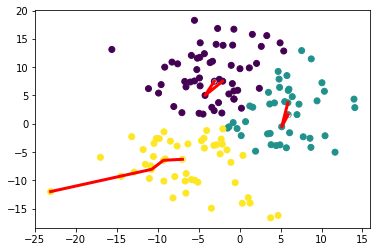

In [5]:
_ = plt.scatter(X[:, 0], X[:, 1], c=cluster_label)
_ = plt.scatter(new_centroids[:,0], new_centroids[:,1], marker='o', s=5, c='r', edgecolors='w', linewidths=2)

plt.plot(np.array(positions)[:,0,0],np.array(positions)[:,0,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,1,0],np.array(positions)[:,1,1],'r',linewidth=3)
plt.plot(np.array(positions)[:,2,0],np.array(positions)[:,2,1],'r',linewidth=3)

## Question 2

Complete the following method to compute the modularity measure of a graph.

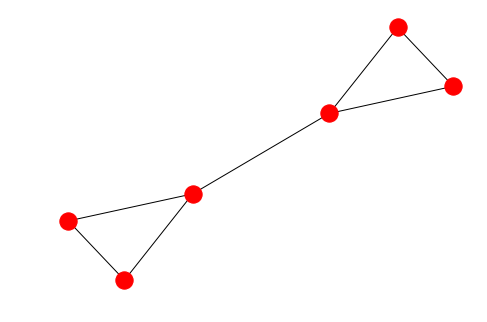

In [12]:
import networkx as nx
import numpy as np

M = ["0,1,2",
     "1,0,2",
     "2,0,1,3",
     "3,2,4,5",
     "4,3,5",
     "5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw(G)

#G = nx.karate_club_graph()
#nx.draw(G)

In [7]:
G.nodes[0]

{'community': 0}

In [4]:
for node in [0,1,2]:
    G.nodes[node]['community'] = 0
for node in [3,4,5]:
    G.nodes[node]['community'] = 1
print(G.degree[2])
print(len(G.edges))
print(len(G.nodes))
print(len(G.node))

3
7
6
6


In [3]:
## If you haven't installed networkx package, you can run the following command (note the exclamation mark)
!conda install networkx --yes 

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.4

Please update conda by running

    $ conda update -n base conda




In [26]:
# The community label of a node can be accessed by G[node_id]['community']
# The degree of a node: G.degree[node_id]
# The neighbors of a node: G.neighbors(node_id)
# Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
def compute_modularity(G):
    
    m = len(G.edges)
    Q = 0
    
    # iterate through the labels
    for label in range(2):
        
        eff_no_edges = 0
        exp_no_edges = 0
        
        # for each node
        for j in range(len(G.node)):
            
            # check if it has the right label
            if not (G.node[j]['community'] == label): continue
                
            # search for all its neighboring nodes
            for k in range(j+1,len(G.node)):
                
                # check if it has the right label
                if not (G.node[k]['community'] == label): continue
                # check if it is the neighbor of node[j]
                if not (k in G.neighbors(j)): continue
                
                # expected number of edges
                exp_no_edges += G.degree[j]*G.degree[k]/(2*m)
                eff_no_edges += 1
                
        Q += exp_no_edges - eff_no_edges
    
    return Q/(2*m)

compute_modularity(G)

-0.2653061224489796

## Pen and Paper

Suppose that you have an undirected social graph G = (U, V), where U - set of nodes, V - set of edges.

<img src="graph.png" width="400">

#### Question

Compute betweenness for the graph G and output the communities for the following betweenness threshold : 4, 6.